In [33]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt

import seaborn as sns
import pandas as pd
import numpy as np


df = pd.read_csv('data.csv')
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,880.0,129,322.0,126.0,8.3252,452600.0,0,0,1,0
1,-122.22,37.86,21.0,7099.0,1106,2401.0,1138.0,8.3014,358500.0,0,0,1,0
2,-122.24,37.85,52.0,1467.0,190,496.0,177.0,7.2574,352100.0,0,0,1,0
3,-122.25,37.85,52.0,1274.0,235,558.0,219.0,5.6431,341300.0,0,0,1,0
4,-122.25,37.85,52.0,1627.0,280,565.0,259.0,3.8462,342200.0,0,0,1,0


### Vanilla implementation of RandomForest

In [23]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split


X  = df.drop('median_house_value', axis=1).values
y = df['median_house_value'].values

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

In [24]:
rf_basic = RandomForestRegressor().fit(X_train, y_train)

y_pred = rf_basic.predict(X_test)
RMSE_basic = abs(mean_squared_error(y_test, y_pred, squared=False))
r2score_basic = r2_score(y_test,y_pred)

In [25]:
print(f'RMSE score: {round(RMSE_basic, 2)}')
print(f'R2_score: {round(r2score_basic, 2)}')

RMSE score: 44928.88
R2_score: 0.79


Let's see if we can improve on these scores with optimization of the model.

### Hyperparameter tuning

In [13]:
### Build random forest with hyperparameters.
# Number of trees in random
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 150, num=6)]
# Number of features to consider at every split 
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = np.linspace(1, 32, num=5)
# Minimum number of samples required to split a node
min_samples_split = [2, 5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [14]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split


X  = df.drop('median_house_value', axis=1).values
y = df['median_house_value'].values

X_train, X_test, y_train, y_test1 = train_test_split(X,y, test_size=0.3, random_state=0)

In [15]:
# Create the param grid
param_grid = {'n_estimators' : n_estimators,
              'max_features' : max_features,
              'max_depth': max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf,
              'bootstrap': bootstrap
            }
print(param_grid)

{'n_estimators': [50, 70, 90, 110, 130, 150], 'max_features': ['auto', 'sqrt'], 'max_depth': array([ 1.  ,  8.75, 16.5 , 24.25, 32.  ]), 'min_samples_split': [2, 5], 'min_samples_leaf': [1, 2], 'bootstrap': [True, False]}


In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Instantiate RandomForestRegressor
rf = RandomForestRegressor()

rf_Grid = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_root_mean_squared_error', verbose=2, n_jobs=5)

rf_Grid.fit(X_train, y_train)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(), n_jobs=5,
             param_grid={'bootstrap': [True, False],
                         'max_depth': array([ 1.  ,  8.75, 16.5 , 24.25, 32.  ]),
                         'max_features': ['auto', 'sqrt'],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [50, 70, 90, 110, 130, 150]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [20]:
rf_Grid.best_params_

{'bootstrap': True,
 'max_depth': 24.25,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 150}

In [21]:
print(f'Train Accuracy: {abs(rf_Grid.score(X_train,y_train))}')
print(f'Test Accuracy: {abs(rf_Grid.score(X_test,y_test))}')

Train Accuracy: 22745.14430001594
Test Accuracy: 44844.99335476753


In [22]:
from sklearn.metrics import r2_score

rf = RandomForestRegressor(**rf_Grid.best_params_)

rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)
RMSE = mean_squared_error(y_test,y_pred, squared=False)
score = r2_score(y_test, y_pred)



In [26]:
# Compare accuracy

print('Vanilla model:')
print(f'RMSE score: {int(RMSE_basic)}')
print(f'R2 score: {round(r2score_basic, 2)}')

print('\n')

print('Optimized model:')
print(f'RMSE score: {int(RMSE)}')
print(f'R2 score: {score}')

Vanilla model:
RMSE score: 44928
R2 score: 0.79


Optimized model:
RMSE score: 44738
R2 score: 0.7916584609202919


We achieved marginal improvement after optimization. 

In [27]:
# Calculating the confidence interval as an indicator for precision of estimate
from scipy import stats

confidence = 0.95
squared_errors = (y_pred - y_test) ** 2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))



array([43362.05313603, 46442.87318647])

The confidence interval shows us that we can be confident that our population estimate is precise.

### Feature Importance by decision trees

Text(0.5, 1.0, 'Feature importance')

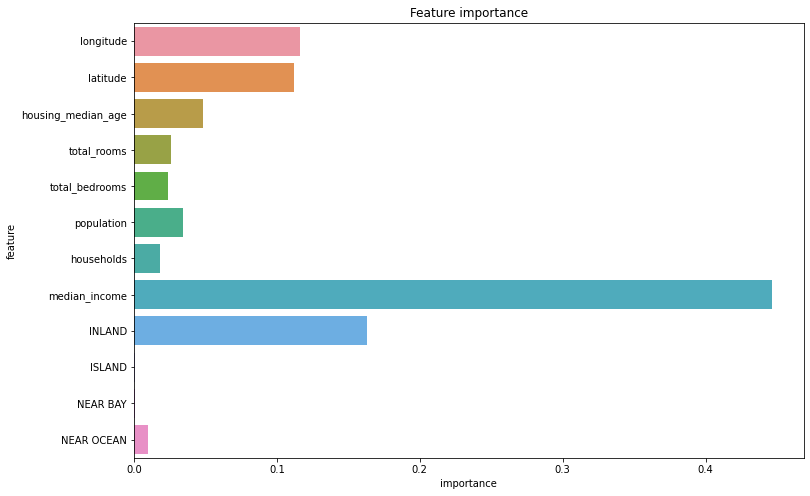

In [35]:
plt.figure(figsize=(12,8))
data=pd.DataFrame({'feature':df.columns[df.columns!='median_house_value'].values, "importance": rf.feature_importances_})

sns.barplot(data=data,y='feature',x='importance')

plt.title('Feature importance')

